# Wikispeedia

### Setup

In [1]:
import pandas as pd
import networkx as nx
import nx_parallel as nxp
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import os
import json

from joblib import parallel_config, Parallel, delayed

Enable networkx's config for nx-parallel and set global configs

In [3]:
nx.config.backends.parallel.active = True

nxp_config = nx.config.backends.parallel
nxp_config.n_jobs = -1

### Load data, preprocessing

Read graph data

In [8]:
links = pd.read_csv('wikispeedia_paths-and-graph/links.tsv', delimiter='\t', names=['linkSource', 'linkTarget'], header=None, comment="#")
articles = pd.read_csv('wikispeedia_paths-and-graph/articles.tsv', delimiter='\t', names=['article'], header=None, comment="#")

Read game data

In [11]:
paths_finished = pd.read_csv('wikispeedia_paths-and-graph/paths_finished.tsv', delimiter='\t', usecols=[3], names=['path'], header=None, comment="#")
paths_finished['target'] = paths_finished['path'].apply(lambda x: x.split(';')[-1])
paths_finished['path'] = paths_finished['path'].apply(lambda x: x.split(';'))

paths_unfinished = pd.read_csv('wikispeedia_paths-and-graph/paths_unfinished.tsv', delimiter='\t', usecols=[3, 4], names=['path', 'target'], header=None, comment="#")
paths_unfinished['path'] = paths_unfinished['path'].apply(lambda x: x.split(';'))

paths = pd.concat([paths_finished, paths_unfinished], ignore_index=True)

Filter game data to discard '<'

In [14]:
filtered_paths = [] 
    
for p in paths['path']:
    indices  = [index for (index, item) in enumerate(p) if item == '<']
    filter_indices = []; 
    for index in indices: filter_indices.extend([index - 1, index])
    filtered_paths.append([item for index, item in enumerate(p) if index not in filter_indices])

Generate the graph

In [17]:
G = nx.from_pandas_edgelist(links, source='linkSource', target='linkTarget', create_using=nx.DiGraph)
disconnected_nodes = set(articles['article'].tolist()) - set(G.nodes)
G.add_nodes_from(disconnected_nodes)

H = nxp.ParallelGraph(G)

### Central article usage by players

Compute the shortest-path betweenness centrality for nodes (not approximated)

In [21]:
nodes_bc = nxp.betweenness_centrality(H);

Article usage by players

In [23]:
sorted_bc = sorted(nodes_bc.items(), key=lambda item: item[1], reverse=True)
percentage_bc = []
percentage_l = []
for i in range(1, 100):
    percentage_bc.append(sorted_bc[i][1])
    percentage_l.append(sorted_bc[i][0])

percentage_finished = []
for i in range(1, 100):
    count = 0
    for path in paths_finished['path']:
        if sorted_bc[i][0] in path:
            count += 1
    percentage_finished.append(count/len(paths_finished['path']))
print()

percentage_unfinished = []
for i in range(1, 100):
    count = 0
    for path in paths_unfinished['path'][1:-1]:
        if sorted_bc[i][0] in path:
            count += 1
    percentage_unfinished.append(count/len(paths_unfinished['path']))

Plot

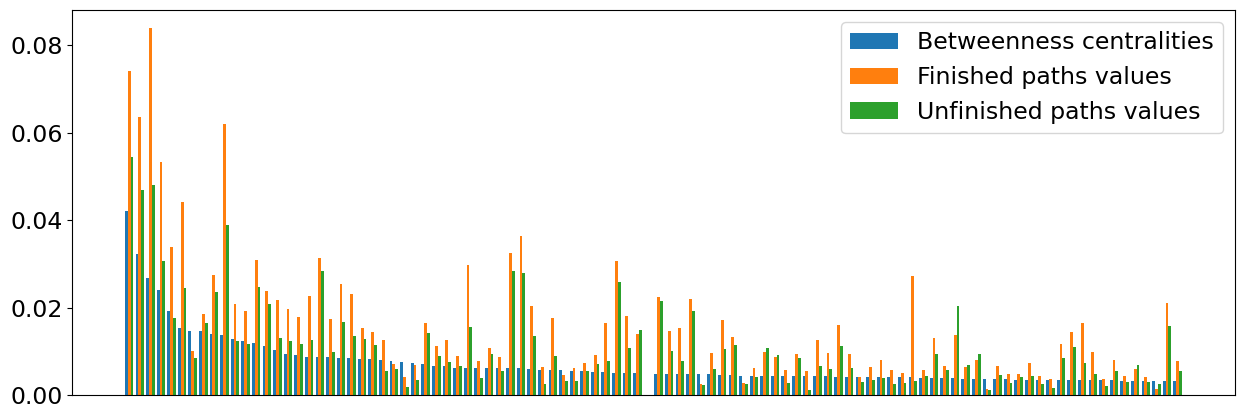

In [32]:
SMALL_SIZE = 17
MEDIUM_SIZE = 17
BIGGER_SIZE = 17

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

_ = plt.figure(figsize=(15, 5))
_ = plt.hist(
    [percentage_l, percentage_l, percentage_l],
    weights=[percentage_bc, percentage_finished, percentage_unfinished],
    align='left',
    label=['Betweenness centralities', 'Finished paths values', 'Unfinished paths values'],
    bins=100,
)
_ = plt.xticks([])
_ = plt.legend()

_ = plt.savefig('BetweennessHist.pdf')

### Player paths analysis

_Runs in $\approx$1m_

In [42]:
unique_couples = []

for index, row in paths.iterrows():
    src = row['path'][0]
    dst = row['target']
    if(not [src, dst] in unique_couples):
        unique_couples.append([src, dst])

Compute all shortest paths 

In [ ]:
def shortest_paths_f(couple):
    try:
        shortest_paths_generator = nx.all_shortest_paths(G, couple[0], couple[1])
        shortest_paths = list(shortest_paths_generator)
        if not os.path.isdir('shortest_paths'):
            os.makedirs('shortest_paths')
        with open('shortest_paths/' + couple[0] + '#' + couple[1] + '.py', 'w') as out_file:
            out_file.write(json.dumps(shortest_paths))
    except Exception as e:
        print(couple[0] + '#' + couple[1] + ' exception : ' + str(e))

_Run to compute the shortest paths, runs in $\approx$1.5h_

_Just computed!_

In [ ]:
Parallel(n_jobs=-1)(delayed(shortest_paths_f)(couple) for couple in unique_couples)

Compute the metrics

In [50]:
def compare_paths(player_path, optimal_paths, output_folder):
   
    best_beg_equal_nodes = 0
    best_end_equal_nodes = 0
    best_total_equal_nodes = 0
        
    for op in optimal_paths:

        i = 0
        while(i < len(op) and i < len(player_path) and player_path[i] == op[i]): i = i + 1
        beg_equal_nodes = i
            
        i = 0
        while(i > -len(op) and i > -len(player_path) and player_path[i - 1] == op[i - 1]): i = i - 1
        end_equal_nodes = -i

        total_equal_nodes = len(list(set(op).intersection(player_path)))

        if beg_equal_nodes > best_beg_equal_nodes: best_beg_equal_nodes = beg_equal_nodes
        if end_equal_nodes > best_end_equal_nodes: best_end_equal_nodes = end_equal_nodes
        if total_equal_nodes > best_total_equal_nodes: best_total_equal_nodes = total_equal_nodes

    try:
        if not os.path.isdir(output_folder):
            os.makedirs(output_folder)
        with open(output_folder + '/' + optimal_paths[0][0] + '#' + optimal_paths[0][-1] + '.txt', 'a') as out_file:
            out_file.write(
                str(len(optimal_paths[0])) + ' ' + 
                str(len(player_path)) + ' ' +
                str(best_beg_equal_nodes) + ' ' + 
                str(best_end_equal_nodes) + ' ' + 
                str(best_total_equal_nodes) + ' ' +
                str(int(player_path[-1] == optimal_paths[0][-1])) + '\n'
            )
            
    except Exception as e:
        print(optimal_paths[0][0] + '#' + optimal_paths[0][-1] + ' exception : ' + str(e))

_Run to compute the metrics, runs in $\approx$5m_

_Just computed!_

In [54]:
for index, row in paths.iterrows():
    optimal_paths = []
    try:
        with open('shortest_paths' + '/' + row['path'][0] + '#' + row['target'] + '.py') as in_file:
            optimal_paths = json.load(in_file)
        compare_paths(row['path'], optimal_paths, 'metrics')
    except Exception as e:
        print(row['path'][0] + '#' + row['target'] + ' exception : ' + str(e))

Bird#Wikipedia_Text_of_the_GNU_Free_Documentation_License exception : [Errno 2] No such file or directory: 'shortest_paths/Bird#Wikipedia_Text_of_the_GNU_Free_Documentation_License.py'
Black_pepper#Long_peper exception : [Errno 2] No such file or directory: 'shortest_paths/Black_pepper#Long_peper.py'
Star_Trek#Test exception : [Errno 2] No such file or directory: 'shortest_paths/Star_Trek#Test.py'
World_War_II#Adolph_Hitler exception : [Errno 2] No such file or directory: 'shortest_paths/World_War_II#Adolph_Hitler.py'
Marco_Polo#Netbook exception : [Errno 2] No such file or directory: 'shortest_paths/Marco_Polo#Netbook.py'
Oasis_%28band%29#Final_Fantasy_%28video_game%29 exception : [Errno 2] No such file or directory: 'shortest_paths/Oasis_%28band%29#Final_Fantasy_%28video_game%29.py'
Watercolor_painting#Podcast exception : [Errno 2] No such file or directory: 'shortest_paths/Watercolor_painting#Podcast.py'
Andrew_Jackson#Christmas exception : [Errno 2] No such file or directory: 'shor

Metrics distributions (_runs in $\approx$2m_)

In [61]:
data = []

for couple in unique_couples:
    try:
        with open('metrics' + '/' + couple[0] + '#' + couple[1] + '.txt') as in_file:
            file_lines = in_file.readlines()
            for line in file_lines:
                s = line.split() 
                v = int(s[0]) - 1  # len
                w = int(s[1]) - 1  # player len
                d = int(s[1]) - int(s[0]) # difference
                x = max(int(s[2]) - 1, 0)  # beg equal edges 
                y = max(int(s[3]) - 1, 0)  # end equal edges
                z = max(int(s[4]) - 1, 0)  # total equal edges
                t = bool(int(s[5])) # finished?
                data.append([v, w, d, x, y, z, t])
    except Exception as e:
        print(couple[0] + '#' + couple[1] + ' exception : ' + str(e))
df = pd.DataFrame(data, columns = ['Optimal length', 'Player length', 'Difference', 'Beg equal edges', 'End equal edges', 'Tot equal edges', 'Finished']) 

Bird#Wikipedia_Text_of_the_GNU_Free_Documentation_License exception : [Errno 2] No such file or directory: 'metrics/Bird#Wikipedia_Text_of_the_GNU_Free_Documentation_License.txt'
Black_pepper#Long_peper exception : [Errno 2] No such file or directory: 'metrics/Black_pepper#Long_peper.txt'
Star_Trek#Test exception : [Errno 2] No such file or directory: 'metrics/Star_Trek#Test.txt'
World_War_II#Adolph_Hitler exception : [Errno 2] No such file or directory: 'metrics/World_War_II#Adolph_Hitler.txt'
Marco_Polo#Netbook exception : [Errno 2] No such file or directory: 'metrics/Marco_Polo#Netbook.txt'
Oasis_%28band%29#Final_Fantasy_%28video_game%29 exception : [Errno 2] No such file or directory: 'metrics/Oasis_%28band%29#Final_Fantasy_%28video_game%29.txt'
Watercolor_painting#Podcast exception : [Errno 2] No such file or directory: 'metrics/Watercolor_painting#Podcast.txt'
Andrew_Jackson#Christmas exception : [Errno 2] No such file or directory: 'metrics/Andrew_Jackson#Christmas.txt'
Music#Sp

Plot

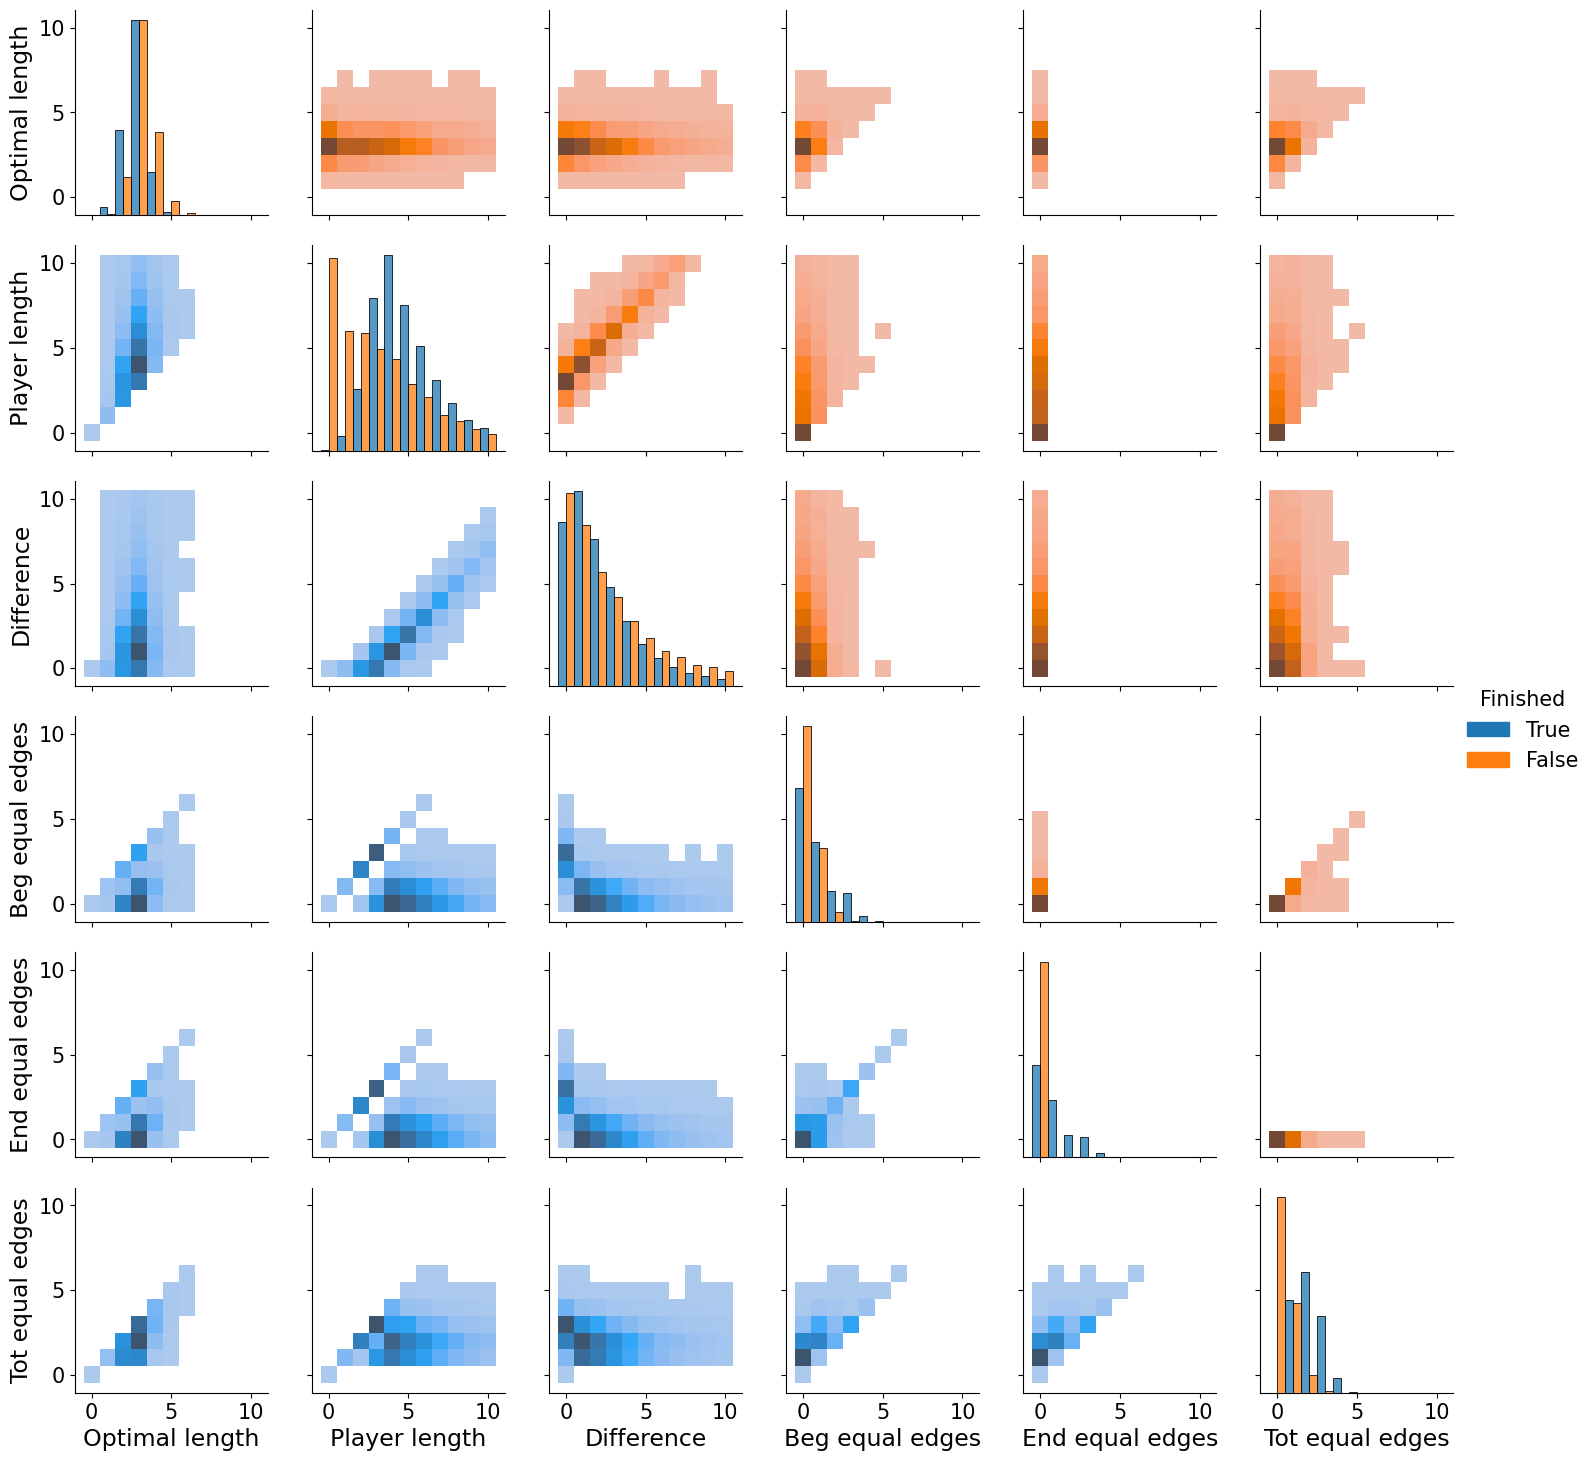

In [70]:
SMALL_SIZE = 15
MEDIUM_SIZE = 17
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

g = sns.PairGrid(df, hue='Finished', hue_order=[True, False], diag_sharey=False)
g.map_diag(sns.histplot, binwidth=1, binrange=(0, 10), multiple='dodge', stat='density', common_norm=False, discrete=True)
g.data = df[df['Finished'] == True]
g.map_lower(sns.histplot, binwidth=1, binrange=(0, 10), discrete=True, stat='density')
g.data = df[df['Finished'] == False]
g.map_upper(sns.histplot, binwidth=1, binrange=(0, 10), discrete=True, stat='density')
g.add_legend()

_ = plt.savefig('ComparisonHue.pdf')

### Shortest paths lengths distribution

Wikispeedia lengths histogram

In [74]:
lengths_dict_G = dict(nx.all_pairs_shortest_path_length(G))
lengths_list_G = []
for src in G.nodes:
        for dst in G.nodes:
            try:
                lengths_list_G.append(lengths_dict_G[src][dst])
            except Exception as e:
                continue

max_len = 10
hist_G = np.histogram(lengths_list_G, bins=range(max_len + 2), density=True)[0]

Random graphs histogram

In [77]:
lengths_list = []
mc_samples = 50

_Run to generate the graphs and evaluate the distances between all the articles_

_Just computed!_

In [ ]:
for i in range(mc_samples):
    print(i)
    GG = nx.directed_configuration_model([G.in_degree(node) for node in G], [G.out_degree(node) for node in G])
    lengths_dict = dict(nx.all_pairs_shortest_path_length(GG))
    sample_lengths = []
    for src in GG.nodes:
        for dst in GG.nodes:
            try:
                sample_lengths.append(lengths_dict[src][dst])
            except Exception as e:
                continue
    lengths_list.append(sample_lengths)

_Load the distances_ 

_File not uploaded on GitHub, it was too large, $\approx$3GB_

In [86]:
with open('random_graphs_distances.py') as in_file:
    lengths_list = json.load(in_file)

In [89]:
hists = []

for l in lengths_list:
    hists.append(np.histogram(l, bins=range(max_len + 2), density=True)[0])

hists = np.array(hists)

In [91]:
hists_mean = np.mean(hists, axis=0)
hists_stds = np.std(hists, axis=0, ddof=1)

In [93]:
z_scores = []
for i in range(max_len + 1):
    z_scores.append((hist_G[i] - hists_mean[i])/hists_stds[i])

C:\Users\rdv01\AppData\Local\Temp\ipykernel_4408\1727826892.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  z_scores.append((hist_G[i] - hists_mean[i])/hists_stds[i])
C:\Users\rdv01\AppData\Local\Temp\ipykernel_4408\1727826892.py:3: RuntimeWarning: invalid value encountered in scalar divide
  z_scores.append((hist_G[i] - hists_mean[i])/hists_stds[i])


Plot

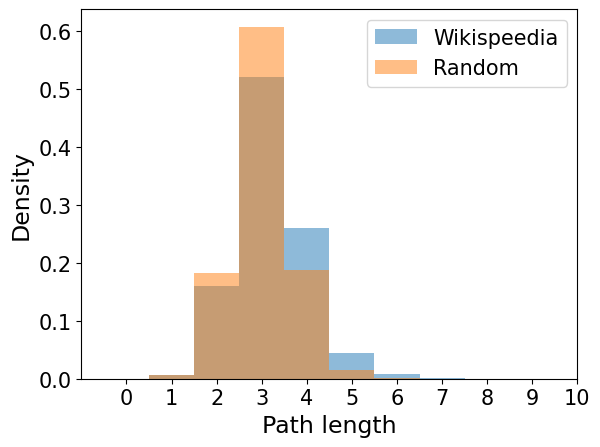

In [96]:
_ = plt.hist(lengths_list_G, bins=range(max_len + 1), density='True', align='left', alpha=0.5, label='Wikispeedia')
_ = plt.hist(range(max_len + 1), weights=hists_mean, bins=range(max_len + 1), align='left', alpha=0.5, label='Random')
_ = plt.xticks(range(max_len + 1))
_ = plt.xlabel('Path length')
_ = plt.ylabel('Density')
_ = plt.legend()

_ = plt.savefig('WikispeediaVSRandom.pdf')